In [ ]:
!pip install numpy pandas matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


LOAD DATASET

In [ ]:

customers = pd.read_csv('df_Customers.csv')
orderItems = pd.read_csv('df_OrderItems.csv')
orders = pd.read_csv('df_Orders.csv')
payments = pd.read_csv('df_Payments.csv')
products = pd.read_csv('df_Products.csv')

DATA CLEANING AND TRANSFORMATION

In [ ]:

orders.head(6)

# removing empty columns
def check_empty_values(tables: dict):
    for name, df in tables.items():
        print(f"\nChecking table: {name}")
        null_counts = df.isnull().sum()
        empty_cols = null_counts[null_counts > 0]

        if not empty_cols.empty:
            print("Columns with empty values:")
            print(empty_cols)
        else:
            print("No empty values found in any column.")

# Dictionary of all tables
tables = {
    'Customers': customers,
    'OrderItems': orderItems,
    'Orders': orders,
    'Payments': payments,
    'Products': products
}

# Run the function
check_empty_values(tables)


Checking table: Customers
No empty values found in any column.

Checking table: OrderItems
No empty values found in any column.

Checking table: Orders
Columns with empty values:
order_approved_at               9
order_delivered_timestamp    1889
dtype: int64

Checking table: Payments
No empty values found in any column.

Checking table: Products
Columns with empty values:
product_category_name    308
product_weight_g          15
product_length_cm         15
product_height_cm         15
product_width_cm          15
dtype: int64


In [ ]:
# dropping empty rows
orders = orders.dropna(subset=['order_approved_at', 'order_delivered_timestamp'])
products = products.dropna(subset=[
    'product_category_name',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm'
])

In [ ]:
# label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

orders.loc[:, 'order_status'] = label_encoder.fit_transform(orders['order_status'])
customers.loc[:, 'customer_state'] = label_encoder.fit_transform(customers['customer_state'])
payments.loc[:, 'payment_type'] = label_encoder.fit_transform(payments['payment_type'])
products.loc[:, 'product_category_name'] = label_encoder.fit_transform(products['product_category_name'])


**PREDICTIVE MODELLING**




1.   Delivery Time Prediction




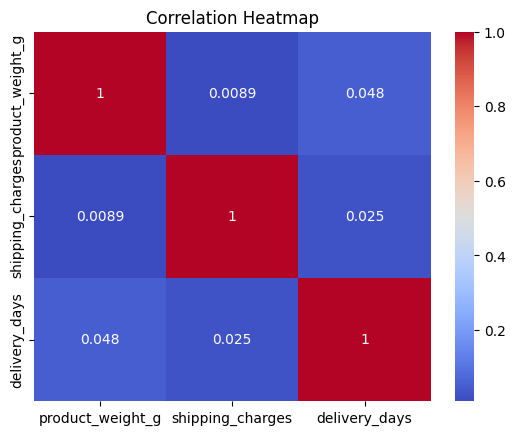

In [ ]:
# Target: (order_delivered_timestamp - order_purchase_timestamp)
# Features: product_weight_g, shipping_charges, state, order_status

# Merging and joining tables
df = orders.merge(orderItems, on='order_id')
df = df.merge(products, on='product_id')
df = df.merge(customers, on='customer_id')

# Create the target variable: delivery_days
df['order_delivered_timestamp'] = pd.to_datetime(df['order_delivered_timestamp'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['delivery_days'] = (df['order_delivered_timestamp'] - df['order_purchase_timestamp']).dt.days

# Filter out invalid or negative delivery times
df = df[df['delivery_days'] >= 0]

# Remove rows with NaNs (if any were introduced in timestamp conversion)
df = df.dropna(subset=['delivery_days'])

# Check correlations with numeric columns only
numeric_df = df[['product_weight_g', 'shipping_charges', 'delivery_days']].dropna()
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# modelling

features = [
    'shipping_charges',
    'price',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm'
]

# Drop rows with any missing numerical values
df_model = df[features + ['delivery_days']].dropna()

# if including categorical columns like state or category later
# df_model = pd.get_dummies(df_model, columns=['customer_state', 'product_category_name'], drop_first=True)

from sklearn.model_selection import train_test_split

X = df_model[features]
y = df_model['delivery_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 2.985220320552236
R2 Score: 0.6301940582899427


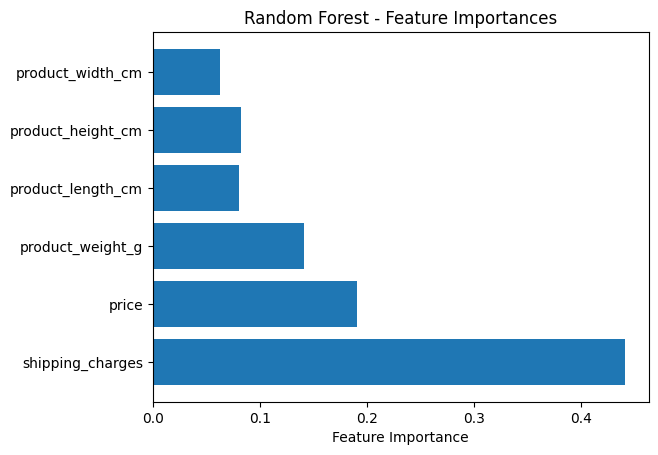

In [ ]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest - Feature Importances")
plt.show()


In [ ]:
# export csv for powerBI
# OPTIONAL: Add order_id and customer_id for reference (if available in your df_model)
export_df = df.loc[X_test.index, ['order_id', 'customer_id'] + features].copy()

# Add actual & predicted delivery days
export_df['Actual_Delivery_Days'] = y_test
export_df['Predicted_Delivery_Days'] = y_pred

# Save to CSV
export_df.to_csv('delivery_time_predictions.csv', index=False)

print("Exported delivery_time_predictions.csv successfully ✅")


Exported delivery_time_predictions.csv successfully ✅




2.   Order Cancellation Prediction



In [ ]:
# Target: order_status == 'canceled'
# Features: payment_type, installments, shipping_charges, product_category

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
print(orders['order_status'].value_counts())   #gives highly imbalanced data => no model can learn pattern for cancellation => safe to leave this

# orders['is_canceled'] = (orders['order_status'] == 'canceled').astype(int)


# # Merge relevant tables
# df = orders.merge(orderItems, on='order_id')
# df = df.merge(products, on='product_id')
# df = df.merge(customers, on='customer_id')

# # Create binary target variable: 1 = canceled, 0 = not canceled
# df['is_canceled'] = (df['order_status'] == 'canceled').astype(int)

# # Drop missing values if any relevant columns have them
# df = df.dropna(subset=['shipping_charges', 'product_weight_g', 'order_status', 'customer_state'])

# # Feature and target selection
# features = ['product_weight_g', 'shipping_charges', 'customer_state']
# target = 'is_canceled'

# X = df[features]
# y = df[target]

# # Class imbalance check
# cancel_counts = y.value_counts()
# neg = cancel_counts.get(0, 0)
# pos = cancel_counts.get(1, 1)  # Use 1 to avoid division by zero

# # Prevent divide-by-zero
# scale_pos_weight = neg / pos if pos != 0 else 1


# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Preprocessing
# numeric_features = ['product_weight_g', 'shipping_charges']
# categorical_features = ['customer_state']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ]
# )

# # Model pipeline
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss'))
# ])

# # Train the model
# pipeline.fit(X_train, y_train)

# # Evaluate
# y_pred = pipeline.predict(X_test)
# print(classification_report(y_test, y_pred))


order_status
1    87413
0        5
Name: count, dtype: int64





3.   Inventory Demand Forecasting






In [ ]:
# Problem: Predict future demand of a product category or SKU.
# Aggregate past order quantities by product and time (e.g. weekly)

# Merge datasets
# Merge orders + orderItems (core)
df = orders.merge(orderItems, on='order_id')

# Merge with products to get product info
df = df.merge(products, on='product_id')

# Optional: Merge with customers if you want geo info (state/city)
df = df.merge(customers, on='customer_id')

# Optional: Merge with payments if payment value matters
df = df.merge(payments, on='order_id')


# First: convert timestamp to datetime
df['order_date'] = pd.to_datetime(df['order_purchase_timestamp'])

# Extract time components
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month

# Group by product + month to get total quantity
demand_df = df.groupby(['product_id', 'product_category_name', 'year', 'month'])['order_id'].count().reset_index()
demand_df.rename(columns={'order_id': 'demand_count'}, inplace=True)

demand_df['prev_month_demand'] = demand_df.groupby('product_id')['demand_count'].shift(1)
demand_df['rolling_3m_avg'] = demand_df.groupby('product_id')['demand_count'].rolling(3).mean().reset_index(0, drop=True)



In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X = demand_df[['month', 'year', 'prev_month_demand', 'rolling_3m_avg']]
y = demand_df['demand_count']

# Handle missing lags (e.g., fillna with 0 or median)
X.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

preds = model.predict(X_test)


<ipython-input-15-7ef0405bd0c1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [ ]:
# Take manual input
month = int(input("Enter the month (1-12): "))
year = int(input("Enter the year (e.g., 2024): "))
prev_month_demand = float(input("Enter the previous month's demand count: "))
rolling_3m_avg = float(input("Enter the rolling 3-month average demand: "))

# Make a DataFrame for prediction
import pandas as pd

manual_input = pd.DataFrame({
    'month': [month],
    'year': [year],
    'prev_month_demand': [prev_month_demand],
    'rolling_3m_avg': [rolling_3m_avg]
})

# (optional) Fillna if needed
manual_input.fillna(0, inplace=True)

# Run prediction
pred = model.predict(manual_input)
print(f"📦 Forecasted demand: {pred[0]:.2f} units")


Enter the month (1-12): 5
Enter the year (e.g., 2024): 2025
Enter the previous month's demand count: 45
Enter the rolling 3-month average demand: 41
📦 Forecasted demand: 32.21 units


In [ ]:
# Prepare export DataFrame
export_df = demand_df.loc[X_test.index, ['product_id', 'product_category_name', 'year', 'month', 'prev_month_demand', 'rolling_3m_avg']].copy()

# Add actual & predicted demand
export_df['Actual_Demand'] = y_test
export_df['Predicted_Demand'] = preds

# Save to CSV
export_df.to_csv('inventory_demand_forecast.csv', index=False)

print("✅ Exported inventory_demand_forecast.csv successfully!")


✅ Exported inventory_demand_forecast.csv successfully!


In [ ]:
# If pred is a DataFrame:
if hasattr(pred, 'values'):
    pred = pred.values

# Force it into 1D
pred = np.ravel(pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")


ValueError: Found input variables with inconsistent numbers of samples: [9616, 1]

4. Customer Segmentation

In [ ]:
# Group customers by purchase behavior.
# Features: Total spend, frequency, recency, product diversity

# Merge customers with orders
customer_orders = pd.merge(orders, customers, on='customer_id', how='left')

# Merge with payments
customer_data = pd.merge(customer_orders, payments, on='order_id', how='left')

# Convert dates
customer_data['order_purchase_timestamp'] = pd.to_datetime(customer_data['order_purchase_timestamp'])

# Convert payment_value to numeric (important!)
customer_data['payment_value'] = pd.to_numeric(customer_data['payment_value'], errors='coerce')

# Set snapshot date (latest date in data + 1)
snapshot_date = customer_data['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# Group by customer
rfm = customer_data.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,   # Recency
    'order_id': 'count',                                                    # Frequency
    'payment_value': 'sum'                                                  # Monetary
}).reset_index()

rfm.rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency',
    'payment_value': 'Monetary'
}, inplace=True)

print(rfm.head())


    customer_id  Recency  Frequency  Monetary
0  000hN1Tzi4iN      303          1    334.34
1  001T2XiQONtX      287          1    232.89
2  005aQnkeGglh      693          1    280.09
3  0075TryJTCaQ      146          1    262.30
4  00D6vdR3ymjv      523          1    151.98


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Standardize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Group by Cluster and show mean of numeric columns
print(rfm.groupby('Cluster').mean(numeric_only=True))


            Recency  Frequency     Monetary
Cluster                                    
0        461.356331        1.0   216.610208
1         90.816249        1.0   210.657423
2        234.536813        1.0  1425.079537
3        260.779452        1.0   198.910914


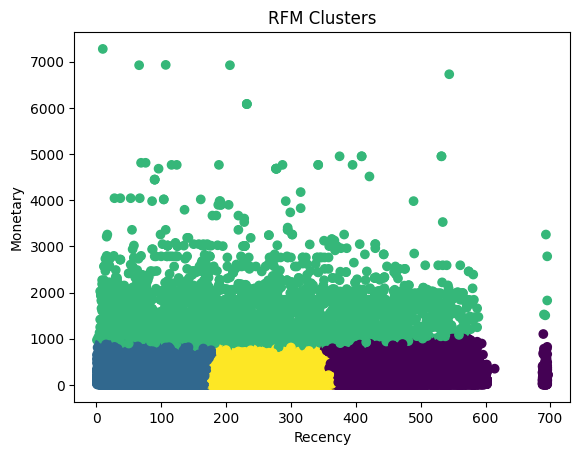

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('RFM Clusters')
plt.show()


In [ ]:
# Optional: Add cluster labels as a new column
output_df = rfm.copy()

# Save to CSV
output_df.to_csv('customer_segmentation.csv', index=False)

print("✅ Exported customer_segmentation.csv successfully!")


✅ Exported customer_segmentation.csv successfully!
